In [1]:
import os
import shutil
from pathlib import Path
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import ogstools as ot
import pyvista as pv
import ogstools as ot
import ogstools.variables as ov

import matplotlib.pyplot as plt
import numpy as np
import os
from subprocess import run

from meshing import create_fractured_cube_centered

## Path

In [2]:
OGS_PATH = None

if OGS_PATH is not None:
    os.environ["OGS_BIN_PATH"] = OGS_PATH
out_dir = Path(os.environ.get("OGS_TESTRUNNER_out_dir", "_out"))
out_dir.mkdir(parents=True, exist_ok=True)
shutil.rmtree(out_dir, ignore_errors=True)


mesh_dir = out_dir / "mesh"

## 3D mesh

In [3]:

MSH_FILE = mesh_dir / "cube_frac_v.msh"
MSH_FILE.parent.mkdir(parents=True, exist_ok=True)
center_z = -100

create_fractured_cube_centered(
    MSH_FILE,
    lc=10, lc_frac=2, L=50.0, H=50.0, T=50.0,
    theta_deg=0.0, b=2,
    center_z=center_z,
)  # structured mesh : b = 4*lc_frac

assert MSH_FILE.is_file(), f"Mesh not written: {MSH_FILE}"

In [4]:
def export_vtu_sets(msh_file: Path):
    out_dir = msh_file.parent
    if not msh_file.is_file():
        raise FileNotFoundError(f"Mesh not found: {msh_file}")

    meshes_dom = ot.meshes_from_gmsh(msh_file, dim=[3], log=False)
    for name, mesh in meshes_dom.items():
        pv.save_meshio(out_dir / f"{name}.vtu", mesh)


export_vtu_sets(MSH_FILE)

In [18]:
cwd = Path.cwd()
os.chdir(mesh_dir)

run(
    f"NodeReordering -o domain.vtu -i domain.vtu",
    shell=True,
    check=True,
)

run(
    "identifySubdomains -f -m domain.vtu -s 1e-8 -- "
    "physical_group_F_*.vtu  physical_group_L_*.vtu physical_group_CENTER.vtu",
    shell=True,
    check=True,
)

os.chdir(cwd)

[2025-10-08 11:52:46.599] [ogs] [info] Reordering nodes... 
[2025-10-08 11:52:46.608] [ogs] [info] Corrected 0 elements.
[2025-10-08 11:52:46.626] [ogs] [info] VTU file written.
[2025-10-08 11:52:46.696] [ogs] [info] Mesh reading time: 0.0287932 s
[2025-10-08 11:52:46.697] [ogs] [info] MeshNodeSearcher construction time: 0.00061162 s
[2025-10-08 11:52:46.697] [ogs] [info] identifySubdomainMesh(): identifySubdomainMeshNodes took 1.1999e-05 s
[2025-10-08 11:52:46.697] [ogs] [info] There is already a 'bulk_node_ids' property present in the subdomain mesh 'physical_group_F_BACK' and it is equal to the newly computed values.
[2025-10-08 11:52:46.700] [ogs] [info] identifySubdomainMesh(): identifySubdomainMeshElements took 0.00389715 s
[2025-10-08 11:52:46.700] [ogs] [info] There is already a 'bulk_element_ids' property present in the subdomain mesh 'physical_group_F_BACK' and it is equal to the newly computed values.
[2025-10-08 11:52:46.701] [ogs] [info] identifySubdomainMesh(): identifySu

## Material propertieses

In [19]:
gneiss = {
    "young_sample": 83.9e9,
    "nu_sample": 0.21,
    "biot": 0.6,
    "porosity": 0.001,
    "permeability": 1e-19,
    "density_solid": 2750,
    "w_init": 1e-6,
}

fault = {
    "young_modulus": gneiss["young_sample"],
    "poisson_ratio": gneiss["nu_sample"],
    "biot": gneiss["biot"],
    "porosity": gneiss["porosity"],
    "density": gneiss["density_solid"],
    "permeability": (gneiss["w_init"] ** 2) / 12.0,
}


rho = 1000.0
g = 9.81
pmax = 5e6

## Run OGS

In [30]:
prj_in = Path("HM_init_3D.prj")
prj_out = out_dir / "HM_init_3D_updated.prj"


matrix_mids = [0, 2]
fault_mids = [1]

prj = ot.Project(input_file=prj_in, output_file=prj_out)
prj.replace_parameter_value(name="E1", value=gneiss["young_sample"])
prj.replace_parameter_value(name="nu1", value=gneiss["nu_sample"])

def set_medium_props(mid, biot, k_perm, poro, rho_solid):
    prj.replace_medium_property_value(mediumid=mid, name="biot_coefficient", value=biot)
    prj.replace_medium_property_value(mediumid=mid, name="permeability", value=k_perm)
    prj.replace_medium_property_value(mediumid=mid, name="porosity", value=poro)
    prj.replace_phase_property_value(mediumid=mid, phase="Solid", name="density", value=rho_solid)

for mid in matrix_mids:
    set_medium_props(mid, gneiss["biot"], gneiss["permeability"], gneiss["porosity"], gneiss["density_solid"])

for mid in fault_mids:
    set_medium_props(mid, fault["biot"], fault["permeability"], fault["porosity"], fault["density"])


p0 = rho * g * (-center_z)
m0 = p0 / pmax
m0 = max(0.0, min(1.0, m0))

coords_str = "0 500 600 700 800 900 1000"
vals = [
    m0, m0,
    m0 + (1 - m0) * 0.2,
    m0 + (1 - m0) * 0.4,
    m0 + (1 - m0) * 0.6,
    m0 + (1 - m0) * 0.8,
    1.0
]
values_str = " ".join(f"{v:.6g}" for v in vals)

print(f"center_z = {center_z} m")
print(f"p0 = {p0/1e6:.3f} MPa")
print(f"m0 = {m0:.5f}")
print("coords:", coords_str)
print("values:", values_str)
prj.replace_text("timeRamp", xpath="./curves/curve/name")              
prj.replace_text(coords_str, xpath="./curves/curve/coords")
prj.replace_text(values_str, xpath="./curves/curve/values")
prj.replace_parameter_value(name="p_injection_rate", value=pmax)

prj.replace_text("genesis_HM_init", xpath="./time_loop/output/prefix")
prj.write_input()


center_z = -100 m
p0 = 0.981 MPa
m0 = 0.19620
coords: 0 500 600 700 800 900 1000
values: 0.1962 0.1962 0.35696 0.51772 0.67848 0.83924 1


In [31]:
prj.run_model(logfile=out_dir / "ogs_run.txt",
              #path="~/Code/ogs6/build/release-lis/bin",
              #path="~/Code/ogs6/build/release-petsc/bin",
              args=f"-o {out_dir} -m {mesh_dir}")

Project file written to output.
Simulation: _out/HM_init_3D_updated.prj
Status: finished successfully.
Execution took 137.35472559928894 s


## Post-processing

In [32]:
ms_c = ot.MeshSeries(out_dir / "genesis_HM_init.pvd")
mesh_c = ms_c[-1]

disp = mesh_c.point_data["displacement"]
mesh_c.point_data["displacement_magnitude"] = np.linalg.norm(disp, axis=1)

plotter = pv.Plotter()
plotter.add_mesh(
    mesh_c,
    scalars="displacement_magnitude",
    cmap="bwr",
    opacity=.95,
    show_edges=True,
    edge_color="black",
    scalar_bar_args={"title": "Displacement magnitude (m)"}
)
plotter.show_bounds(grid="front", location="outer", all_edges=True, xtitle="X", ytitle="Y", ztitle="Z", font_size=12)
plotter.add_axes()
plotter.show()

Widget(value='<iframe src="http://localhost:43687/index.html?ui=P_0x7b914a023610_1&reconnect=auto" class="pyvi…

100%|████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 35.60it/s]


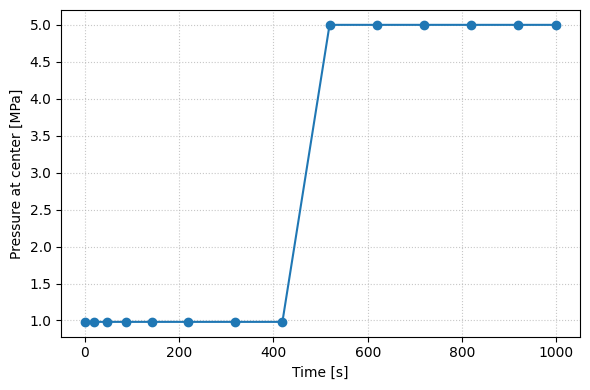

In [33]:
pvd_path = Path("_out/genesis_HM_init.pvd")
center = (0.0, 0.0, center_z)

ms = ot.MeshSeries(pvd_path).scale(time=("s", "s"))
probe = ot.MeshSeries.extract_probe(ms, [center])

t = probe.timevalues
p_pa = probe.point_data["pressure"][:, 0]
p_mpa = p_pa / 1e6

plt.figure(figsize=(6, 4))
plt.plot(t, p_mpa, marker="o", color="tab:blue")
plt.xlabel("Time [s]")
plt.ylabel("Pressure at center [MPa]")
plt.grid(True, linestyle=":", alpha=0.7)
plt.tight_layout()
plt.show()
